# Проект по продвинутому SQL

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

### Задание 1.1

Найдите количество вопросов, которые набрали больше 300 очков или как минимум 100 раз были добавлены в «Закладки».

In [2]:
query_q = '''
SELECT count(id)
FROM stackoverflow.posts
where (score > 300 or favorites_count >= 100) and (parent_id=0);
'''

### Задание 1.2

Сколько в среднем в день задавали вопросов с 1 по 18 ноября 2008 включительно? Результат округлите до целого числа.

In [3]:
query_w = '''
select round(avg(sel.count))
from 
(select count(id)
from stackoverflow.posts
where parent_id = 0
group by creation_date::date
having creation_date::date between '2008-11-01' and '2008-11-18'
) as sel;
'''

### Задание 1.3

Сколько пользователей получили значки сразу в день регистрации? Выведите количество уникальных пользователей.

In [4]:
query_e = '''
select count(distinct(b.user_id))
from stackoverflow.badges as b
left join stackoverflow.users as us on us.id = b.user_id
where b.creation_date::date = us.creation_date::date;
'''

### Задание 1.4

Сколько уникальных постов пользователя с именем Joel Coehoorn получили хотя бы один голос?

In [5]:
query_r = '''
select count(distinct(p.id))
from stackoverflow.posts as p
left join stackoverflow.users as us on us.id = p.user_id
left join stackoverflow.votes as v on p.id = v.post_id
where (us.display_name like 'Joel Coehoorn') and (v.id > 0);
'''

### Задание 1.5

Выгрузите все поля таблицы vote_types. Добавьте к таблице поле rank, в которое войдут номера записей в обратном порядке. Таблица должна быть отсортирована по полю id.

In [6]:
query_t = '''
select *,
    rank() over (ORDER BY id desc)
from stackoverflow.vote_types
order by rank() over (ORDER BY id);
'''

### Задание 1.6

Отберите 10 пользователей, которые поставили больше всего голосов типа Close. Отобразите таблицу из двух полей: идентификатором пользователя и количеством голосов. Отсортируйте данные сначала по убыванию количества голосов, потом по убыванию значения идентификатора пользователя.

In [8]:
query_y = '''
select v.user_id, count(v.id)
from stackoverflow.votes as v
left join stackoverflow.vote_types as vt on vt.id = v.vote_type_id
where vt.name like 'Close'
group by v.user_id
order by count(v.id) desc, v.user_id desc
limit 10;
'''

### Задание 1.7

Отберите 10 пользователей по количеству значков, полученных в период с 15 ноября по 15 декабря 2008 года включительно.
Отобразите несколько полей:
 - идентификатор пользователя;
 - число значков;
 - место в рейтинге — чем больше значков, тем выше рейтинг.
 
Пользователям, которые набрали одинаковое количество значков, присвойте одно и то же место в рейтинге.
Отсортируйте записи по количеству значков по убыванию, а затем по возрастанию значения идентификатора пользователя.

In [9]:
query_u = '''
select user_id, count(id),
    dense_rank() over (order by count(id) desc)
from stackoverflow.badges as b
where creation_date::date between '2008-11-15' and '2008-12-15'
group by b.user_id
order by count(b.id) desc, b.user_id 
limit 10;
'''

### Задание 1.8

Сколько в среднем очков получает пост каждого пользователя?
Сформируйте таблицу из следующих полей:
 - заголовок поста;
 - идентификатор пользователя;
 - число очков поста;
 - среднее число очков пользователя за пост, округлённое до целого числа.
    
Не учитывайте посты без заголовка, а также те, что набрали ноль очков.

In [14]:
query_i = '''
select title, id, score, round(avg)
from(
    select p.title as title, p.user_id as id, p.score as score,
    avg(score) over (partition by p.user_id) as avg
    from stackoverflow.posts as p
    where not p.title is null and p.score != 0
    ) as w;
'''

### Задание 1.9

Отобразите заголовки постов, которые были написаны пользователями, получившими более 1000 значков. Посты без заголовков не должны попасть в список.

In [15]:
query_o = '''
select title
from stackoverflow.posts as p
where user_id in  (select user_id 
                   from stackoverflow.badges 
                   group by user_id
                   HAVING COUNT(id) >1000
                    )
and (p.title is not null);
'''

### Задание 1.10

Напишите запрос, который выгрузит данные о пользователях из США (англ. United States). Разделите пользователей на три группы в зависимости от количества просмотров их профилей:
 - пользователям с числом просмотров больше либо равным 350 присвойте группу 1;
 - пользователям с числом просмотров меньше 350, но больше либо равно 100 — группу 2;
 - пользователям с числом просмотров меньше 100 — группу 3.
 
Отобразите в итоговой таблице идентификатор пользователя, количество просмотров профиля и группу. Пользователи с нулевым количеством постов не должны войти в итоговую таблицу.

In [10]:
query_p = '''
select id, views, 
    case when views >= 350 then 1
        when views < 350 and views >= 100 then 2
        when views < 100 then 3
    end as group
from stackoverflow.users
where location LIKE '%United States%' and views > 0;
'''

### Задание 1.11

Дополните предыдущий запрос. Отобразите лидеров каждой группы — пользователей, которые набрали максимальное число просмотров в своей группе. Выведите поля с идентификатором пользователя, группой и количеством просмотров. Отсортируйте таблицу по убыванию просмотров, а затем по возрастанию значения идентификатора.

In [11]:
query_a = '''
select d.id, d.views, d.group
from
(select w.id, w.views, w.group,
        MAX(w.views) OVER (PARTITION BY w.group) AS max     
from (
    select id, views, 
    case when views >= 350 then 1
        when views < 350 and views >= 100 then 2
        when views < 100 then 3
    end as group
from stackoverflow.users
where location LIKE '%United States%' and views > 0) as w) as d
where d.views=d.max
order by views desc, id;
'''

### Задание 1.12

Посчитайте ежедневный прирост новых пользователей в ноябре 2008 года. Сформируйте таблицу с полями:
 - номер дня;
 - число пользователей, зарегистрированных в этот день;
 - сумму пользователей с накоплением.

In [12]:
query_s = '''
select dayy, cnt, sum(cnt) over(order by dayy)
from (
    select extract(day from creation_date::date) as dayy, count(id) as cnt
from stackoverflow.users
where creation_date::date between '2008-11-01' and '2008-11-30'
group by dayy
    ) as d;
'''

### Задание 1.13

Для каждого пользователя, который написал хотя бы один пост, найдите интервал между регистрацией и временем создания первого поста. Отобразите:
 - идентификатор пользователя;
 - разницу во времени между регистрацией и первым постом.

In [13]:
query_d = '''
select w.id, (w.min - w.cr) as dif
from (
    select distinct u.id as id, u.creation_date as cr,
    min(p.creation_date) over (partition by u.id) as min
from stackoverflow.users as u
right join stackoverflow.posts as p on u.id = p.user_id) as w;
'''

## Вторая часть проекта

### Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [6]:
query_1 = '''
SELECT date_trunc('month',creation_date::date) as month_date, 
    sum(views_count) as total_views
FROM stackoverflow.posts
WHERE date_trunc('year',creation_date::date) = '2008-01-01'
GROUP BY month_date
ORDER BY total_views desc;
'''

### Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [8]:
query_2 = '''
SELECT u.display_name, COUNT(DISTINCT(p.user_id))
FROM stackoverflow.users as u
LEFT JOIN stackoverflow.posts as p ON p.user_id = u.id
RIGHT JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
WHERE (pt.type LIKE '%%Answer%%') AND 
    (p.creation_date::date between u.creation_date::date and (u.creation_date::date + INTERVAL'1 month'))
GROUP BY u.display_name
HAVING count(p.id)>100
ORDER BY u.display_name;
'''

### Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [10]:
query_3 = '''
with s as 
    (select u.id
    from stackoverflow.posts as p
    join stackoverflow.users as u on p.user_id = u.id
    where date_trunc('month', p.creation_date::date) = '2008-12-01' 
        and date_trunc('month', u.creation_date::date) = '2008-09-01'
    GROUP BY u.id
    HAVING COUNT(p.id) > 0)
select to_char(p.creation_date::timestamp, 'yyyy-mm') as month, count(p.id)
from stackoverflow.posts as p
where p.user_id in (select* from s) and date_trunc('year', p.creation_date::date) = '2008-01-01'
group by  to_char(p.creation_date::timestamp, 'yyyy-mm')
order by to_char(p.creation_date::timestamp, 'yyyy-mm') desc;
'''

### Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [12]:
query_4 = '''
select p.user_id, p.creation_date, p.views_count, 
    sum(p.views_count) over (partition by p.user_id order by p.creation_date) as cumulative_count
from stackoverflow.posts as p;
'''

### Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [14]:
query_5= '''
with u as (select p.user_id,
            date_trunc('day', p.creation_date::date),
            count(p.id)
            from stackoverflow.posts as p
            where p.user_id in (select p.user_id
                                from stackoverflow.posts as p
                                where  date_trunc('month',p.creation_date::date) = '2008-08-01'
                                group by p.user_id
                                having count(p.id) > 120)
            group by  p.user_id, date_trunc('day', p.creation_date::date))
select user_id, avg(count) as avg_daily
from u
where date_trunc('month', date_trunc) = '2008-08-01'
group by user_id
order by avg(count);
'''

### Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

In [16]:
query_6= '''
SELECT ROUND(AVG(g.count))
FROM (select user_id,
                   count(DISTINCT creation_date::date)
            FROM stackoverflow.posts
            WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07' 
            GROUP BY user_id) as g
'''

### Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

In [18]:
query_7 = '''
with time as (select user_id, creation_date,
    lag(creation_date::date, 2) over(partition by user_id order by creation_date)
    from stackoverflow.posts as p
    order by user_id, creation_date)
select user_id, creation_date,  to_char(lag, 'Month')      
from time
'''

### Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

In [20]:
query_8 = '''
with profile as (select *, 
                        count(user_id) OVER(PARTITION BY cohort_dt) AS cohort_users_cnt
                from (select distinct user_id, 
                        first_value(date_trunc('month', creation_date::date)) 
                        over (partition by user_id order by date_trunc('month', creation_date::date)) as cohort_dt             
                from stackoverflow.posts) as g),
                
sessions as  (SELECT user_id,
                date_trunc('month', creation_date::date) AS session_date
                FROM stackoverflow.posts
                GROUP BY user_id, date_trunc('month', creation_date::date)
                )
                
select p.cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile as p 
JOIN sessions as s ON p.user_id=s.user_id
GROUP BY p.cohort_dt, s.session_date, p.cohort_users_cnt;
'''

Построим тепловую карту Retention Rate. 

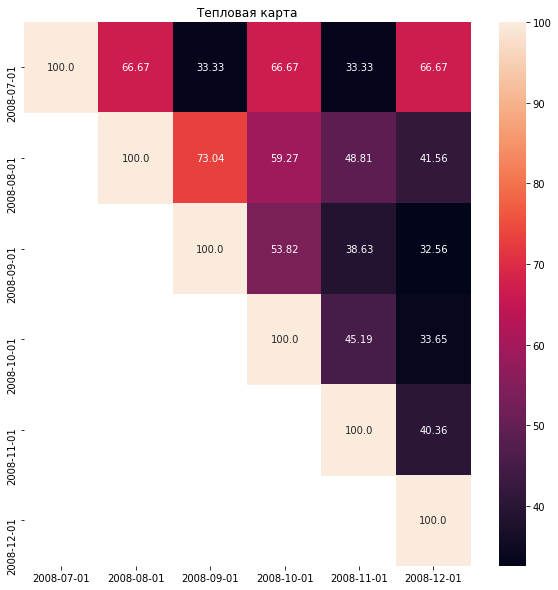

In [22]:
# Retention Rate
import seaborn as sns
retention_rate_8 = n_8.pivot('cohort_dt', 'session_date', 'retention_rate')
retention_rate_8.index = [str(x)[0:10] for x in retention_rate_8.index]
retention_rate_8.columns = [str(x)[0:10] for x in retention_rate_8.columns]
plt.figure(figsize=(10, 10)) 
sns.heatmap(retention_rate_8, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта') 
plt.show() 

Пользователи зарегистрированные в июле имеют "скачки" удержания активности, с одинаковой периодичностью, возможно это технические ошибки, а возможно так и есть. В остальных когортах удержание активности снижается по экспоненте(чем дальше, тем меньше).

### Задание 9

На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

In [23]:
query_9 = '''
WITH m AS (SELECT EXTRACT(MONTH from creation_date::date) AS creation_month,
                    COUNT(DISTINCT id)  as posts_count   
                    FROM stackoverflow.posts
                    WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
                    GROUP BY creation_month)

SELECT *,
       ROUND(((posts_count::numeric / LAG(posts_count) OVER (ORDER BY creation_month)) - 1) * 100, 2) AS percentage
FROM m;
'''

<AxesSubplot:ylabel='posts_count'>

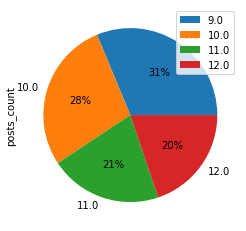

In [25]:
# построим круговую диаграмму с количеством постов по месяцам
n_9.groupby(['creation_month']).sum().plot(kind='pie', y='posts_count', autopct='%1.0f%%')

### Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [26]:
query_10= '''
WITH u AS (SELECT user_id,
                   COUNT(DISTINCT id)
                   FROM stackoverflow.posts
                   GROUP BY user_id
                   ORDER BY COUNT(DISTINCT id) DESC
                   LIMIT 1),

     time AS (SELECT p.user_id,
             p.creation_date,
             extract('week' from p.creation_date) AS week_number
             FROM stackoverflow.posts AS p
             JOIN u ON u.user_id = p.user_id
             WHERE DATE_TRUNC('month', p.creation_date)::date = '2008-10-01')

SELECT DISTINCT week_number::numeric as week_creation,
       MAX(creation_date) OVER (PARTITION BY week_number) AS creation_date
FROM time
ORDER BY week_creation;
'''